In [1]:
from functools import partial
from itertools import starmap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
# Set font to Arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

from scipy.ndimage import uniform_filter as unifilt
from scipy.signal import coherence, find_peaks

from iEEG_utils.loading import read_data
from iEEG_utils.processing import filtering, fooof_mod
from fooof.utils import interpolate_spectra
# pymultitaper - https://github.com/fncokg/pymultitaper
from pymultitaper import multitaper_spectrogram

rng = np.random.default_rng()

C:\Users\jmile3\python\envs\iEEG_analysis\Lib\site-packages\GRID_lab_python\iEEG_utils\processing\fooof_mod.py:14: DeprecationWarning: 
The `fooof` package is being deprecated and replaced by the `specparam` (spectral parameterization) package.
This version of `fooof` (1.1) is fully functional, but will not be further updated.
New projects are recommended to update to using `specparam` (see Changelog for details).
  from fooof import FOOOFGroup


In [2]:
# use file selection dialog to choose folder with data storage
fstr = read_data.select_directory()
print(fstr)

C:\Users\jmile3\OneDrive - SCH\emotional_faces_data\c25ccc\RestingState


In [3]:
# IF following JTM's data processing workflow
#### i.e.: 
#### iEEG.csv of timeseries for regions of interest
#### montage.csv of research montage info
#### channels.csv with metadata (loosely following iEEG-BIDS)
# the next line will load the iEEG.csv file and metadata
# can set load_meta = False to just load the timeseries data
# will need sampling rate, though (typically in "channels.csv")

montage = read_data.load_info(fstr,ftype="montage")
montage.name = montage.name.replace(" ","",regex=True)
srate,data = read_data.load_iEEG(fstr,load_meta=True)
# newcols = list(map(lambda x: x.replace(" ",""),data.columns))
data.rename(mapper=dict(zip(data.columns,list(map(lambda x: x.replace(" ",""),data.columns)))),axis='columns',inplace=True)
if data.index.name == "time":
    data = data.reset_index()
origtime = pd.to_datetime(data.time,format='%H:%M:%S.%f')
origts = np.array(origtime-origtime[0])/ np.timedelta64(1, 's')

print(srate)
print(data.shape)

display(data.head())

1000
(316000, 21)


,time,LM_6,LM_7,RM_10,RM_11,RP_1,RP_2,RP_11,RP_12,LQ_1,...,LQ_3,RQ_1,RQ_2,LS_1,LS_2,LS_13,LS_14,LT_1,LT_2,DC1
0,11:29:44.800036,89.488936,46.036549,-102.962223,-12.905809,-75.402144,-27.792276,102.967223,124.559305,-30.675690,...,-70.708214,-19.745537,28.736062,-123.481406,-171.091275,-58.503994,-48.378515,1.310095,-68.763585,28.601949
1,11:29:44.801036,81.375142,37.922755,-103.498672,-13.643427,-75.268032,-28.462837,102.095493,123.687575,-32.150925,...,-65.544890,-28.462837,33.832329,-121.134441,-175.986374,-66.483676,-49.786694,3.455892,-63.600261,112.489197
2,11:29:44.802036,68.232136,25.517366,-106.247975,-16.526842,-73.658684,-27.725219,99.748528,123.486406,-37.917755,...,-61.119184,-37.917755,36.715744,-118.049858,-180.143856,-73.658684,-50.457255,6.339306,-60.649791,268.461809
3,11:29:44.803036,57.234927,14.587213,-110.472512,-18.739695,-72.786954,-28.395781,96.731001,121.139441,-44.422201,...,-59.576892,-45.830381,36.648688,-117.915745,-185.709516,-82.979490,-52.535996,8.485103,-60.582734,390.638120
4,11:29:44.804036,46.975335,6.540475,-111.008962,-19.410256,-69.769427,-26.115872,93.646418,117.317240,-49.518469,...,-57.364039,-47.976178,35.911070,-114.093545,-187.654145,-87.941645,-51.731322,11.301462,-59.778061,379.171518


In [4]:
montage

,ID,age,region,ch,name
0,c25ccc,12,l_medialorbitofrontal,102,LS_1
1,c25ccc,12,l_medialorbitofrontal,103,LS_2
2,c25ccc,12,l_rostralmiddlefrontal,114,LS_13
3,c25ccc,12,l_rostralmiddlefrontal,115,LS_14
4,c25ccc,12,l_insula,50,LQ_1
5,c25ccc,12,l_insula,51,LQ_2
6,c25ccc,12,l_insula,52,LQ_3
7,c25ccc,12,l_caudalanteriorcingulate,118,LT_1
8,c25ccc,12,l_caudalanteriorcingulate,119,LT_2
9,c25ccc,12,l_precentral,5,LM_6


In [5]:
# # trim resting for a5a41c
# trim_t = 240
# data = data.loc[origts<=trim_t,:]
# origts = origts[origts<=trim_t]

In [6]:
# # mask resting noise for c5ec4c
# mask = (origts>208) & (origts<213)
# data.loc[mask,:] = 0

In [5]:
# rate to resample to (best if power of 2)
resrate = 1024
# upper bound of frequency range (must be < resrate/2)
lpfreq = 150
ch1 = "LQ_1"
ch2 = "LQ_2"
ts,reref1,filtwins1 = filtering.bipolar_reref(data.loc[:,[ch1,ch2]], srate, resrate, lpfreq=lpfreq)
ch3 = "LT_1"
ch4 = "LT_2"
ts,reref2,filtwins2 = filtering.bipolar_reref(data.loc[:,[ch3,ch4]], srate, resrate, lpfreq=lpfreq)

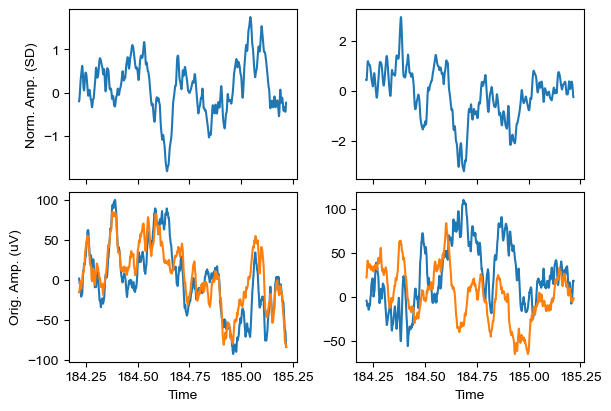

In [7]:
t1 = rng.integers(resrate, high=len(reref1))
t0 = t1-resrate
tfilt = (origts>=ts[t0]) & (origts<=ts[t1])
fig, ax = plt.subplots(2,2,sharex=True,figsize=[6,4],layout='constrained')
ax = ax.flatten()
# reref 1
ax[0].plot(ts[t0:t1],reref1[t0:t1])
ax[2].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch1],data.loc[tfilt,ch2]]).T,srate,4,[59,61],"stop"))
ax[0].set_xlabel("")
ax[2].set_xlabel("Time")
ax[0].set_ylabel("Norm. Amp. (SD)")
ax[2].set_ylabel("Orig. Amp. (uV)")

# reref2
ax[1].plot(ts[t0:t1],reref2[t0:t1])
ax[3].plot(origts[tfilt], filtering.bfilt(np.array([data.loc[tfilt,ch3],data.loc[tfilt,ch4]]).T,srate,4,[59,61],"stop"))
ax[1].set_xlabel("")
ax[3].set_xlabel("Time")

plt.show()

In [22]:
sum(~filtwins2)

array([   0, 1070])

In [23]:
# mask out potential epileptiform activity
reref1[filtwins1.sum(axis=-1)<2] = 0
reref2[filtwins2.sum(axis=-1)<2] = 0

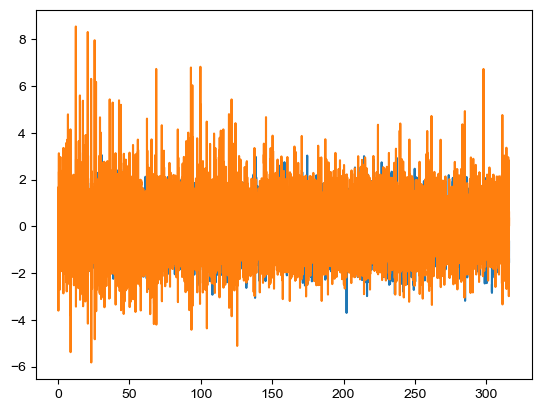

In [24]:
# test = (ts>205) & (ts<215)
# plt.plot(ts[test],reref2[test])
plt.plot(ts,np.array([reref1,reref2]).T)

In [25]:
# set some parameters that will be used for processing
#####
t_res = 1/2 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 10 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

win_samps,centers = filtering.window_data(reref1, resrate, t_res = t_res, t_win = t_win)
cohf, coh_mat = coherence(reref1[win_samps], reref2[win_samps], fs=resrate, window=("hann"),
                          nperseg=(resrate), noverlap=(resrate)*t_res,
                          nfft=t_win*resrate, detrend=None, axis=-1)


In [13]:
# # mask resting noise for c5ec4c
# cohmask = (ts[centers]>208) & (ts[centers]<213)

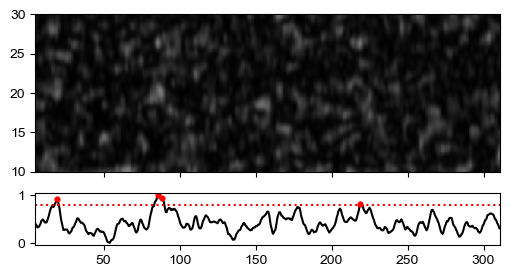

In [26]:
plotf = (cohf>=0.5)&(cohf<=100)
t0 = 5
t1 = max(ts)-5
cohtfilt = (ts[centers]>t0) & (ts[centers]<=t1)

# do some light smoothing of adjacent frequencies and timepoints
# (rows are temporally adjacent with t_res (sec) offset
smoothcoh = unifilt(coh_mat, [5,9], mode="nearest",)
betacoh = smoothcoh[:,(cohf>=15)&(cohf<=30)].mean(axis=-1)
# betacoh[cohmask] = np.nan
betapct = (betacoh-min(betacoh))/(max(betacoh)-min(betacoh))
pk_ixs, pk_props = find_peaks(betapct, height=0.8, threshold=None, distance=4, 
                              prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None)
fig = plt.figure(figsize=[6,3])
grid = GridSpec(2,1, height_ratios=[3,1])
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0],sharex=ax1)
# ax3 = fig.add_subplot(grid[0,1])

ax1.pcolormesh(ts[centers][cohtfilt],cohf,smoothcoh[cohtfilt,:].T,
                    cmap="grey", shading="nearest", vmin=0, vmax=0.66)
ax1.set_ylim([fmin,fmax])
ax1.set_ylim([10,30])
# ax1.set_yscale("log")

ax2.plot(ts[centers][cohtfilt],betapct[cohtfilt],"k")
ax2.plot([t0,t1],[0.8,0.8],"r:")
ax2.scatter(ts[centers][pk_ixs], pk_props["peak_heights"], s=12, c="r",zorder=2)
ax2.set_xlim([t0,t1])
ax2.set_ylim([-0.05,1.05])

plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

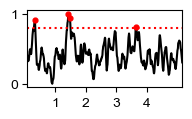

In [27]:
fig = plt.figure(figsize=[2,1])
plt.plot(ts[centers][cohtfilt],betapct[cohtfilt],"k")
plt.plot([t0,t1],[0.8,0.8],"r:")
plt.scatter(ts[centers][pk_ixs], pk_props["peak_heights"], s=12, c="r",zorder=2)
plt.xlim([t0,t1])
plt.ylim([-0.05,1.05])
plt.xticks([60,120,180,240], labels=[1,2,3,4])
plt.show()

In [28]:
beta_rate = len(pk_ixs)/(max(ts)/60.) #BPM
print(beta_rate)

0.7594948444528228


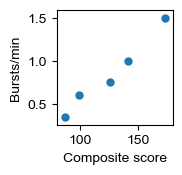

In [21]:
plt.figure(figsize=(1.5,1.5))
plt.scatter([126, 87, 99, 141, 173], [0.76, 0.35, 0.60, 1.0, 1.5], s=25)
plt.xlabel("Composite score")
plt.ylabel("Bursts/min")
plt.xlim(80, 180)
plt.ylim([0.25, 1.6])
plt.show()

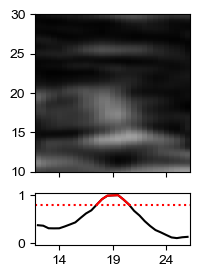

In [103]:
plotf = (cohf>=0.5)&(cohf<=100)
# no beta burst
t0 = 177.75
t1 = 192.25 
# beta burst
t0 = 11.75
t1 = 26.25 
cohtfilt = (ts[centers]>t0) & (ts[centers]<=t1)

fig = plt.figure(figsize=[2,3])
grid = GridSpec(2,1, height_ratios=[3,1])
ax1 = fig.add_subplot(grid[0,0])
ax2 = fig.add_subplot(grid[1,0],sharex=ax1)
# ax3 = fig.add_subplot(grid[0,1])

ax1.pcolormesh(ts[centers][cohtfilt],cohf,smoothcoh[cohtfilt,:].T,
                    cmap="grey", shading="nearest", vmin=0, vmax=0.66)
ax1.set_ylim([fmin,fmax])
ax1.set_ylim([10,30])

ax2.plot(ts[centers][cohtfilt],betapct[cohtfilt],"k")
ax2.plot([t0,t1],[0.8,0.8],"r:")
ax2.set_xlim([t0,t1])
ax2.set_ylim([-0.05,1.05])
ax2.set_xticks([14, 19, 24])

# highlight beta burst in beta coh trace
tfilt = (ts[centers]>17.5) & (ts[centers]<=21.)
ax2.plot(ts[centers][tfilt], betapct[tfilt],"r")

# ax3.set_yscale("log")

plt.setp(ax1.get_xticklabels(), visible=False)
plt.show()

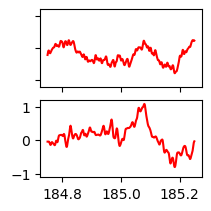

In [75]:
fig,axes = plt.subplots(2,1,figsize=[2,2], layout="constrained")
# zoom in to show beta burst in neural data
# tfilt = (ts>18.75) & (ts<=19.25)
tfilt = (ts>184.75) & (ts<=185.25)
axes[0].plot(ts[tfilt], reref1[tfilt],"r")
axes[0].set_ylim([-0.6,0.6])
axes[0].set_yticklabels([])
axes[0].set_xticklabels([])
axes[1].plot(ts[tfilt], reref2[tfilt],"r")
axes[1].set_ylim(np.array([-1.5,0.8])+0.4)

plt.show()

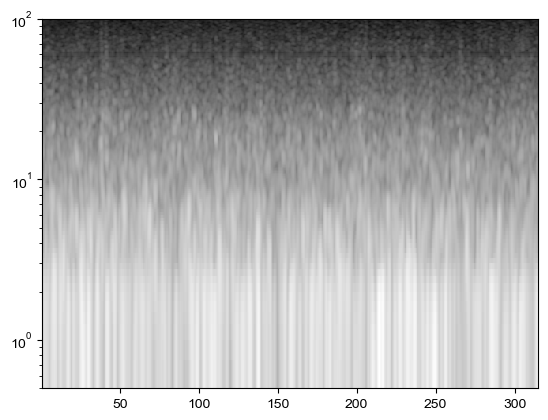

In [41]:
# set some parameters that will be used for processing
#####
t_res = 1/2 # time between spectra calculations (seconds)
f_res = 1/2 # frequency bin size for spectra (Hz)
t_win = 2 # in seconds
fmin = 0.5 # minimum frequency to save
fmax = 100 # max frequency to save (should be below 256)
####

f,sts,spectra = multitaper_spectrogram(reref1,resrate,time_step=t_res,window_length=t_win,NW=3,
                                       detrend='off',freq_range=[fmin, fmax],nfft=2*t_win*resrate,
                                       db_scale=False,boundary_pad=False)

# do some light smoothing of adjacent frequencies and timepoints
# (rows are temporally adjacent with t_res (sec) offset
smoothspect = unifilt(spectra, [5,3], mode="nearest",)
# interpolate over 60 Hz line noise to make fitting better
_,spectra = interpolate_spectra(f, smoothspect.T, [58.5,61.5], buffer=5)
fig, ax = plt.subplots()
ax.pcolormesh(sts,f,np.log10(spectra[1:,1:].T),cmap="grey", shading="flat")
ax.set_ylim([fmin,fmax])
ax.set_yscale("log")
plt.show()

In [42]:
# fit 1/f with Lorentzian
spect_fits = fooof_mod.fit_group(f,spectra)


Running FOOOFGroup across 629 power spectra.


In [43]:
model_spect = fooof_mod.model_spect
intfs = np.concatenate((np.linspace(0.5,1,sum(f>50)+1),np.linspace(1.05,10,sum(f>10)),f[f>10]))
rowixs = [[ix] for ix in range(spectra.shape[0])]
partial_func = partial(model_spect,model_obj=spect_fits,freqs=f,intfs=intfs,save_fit=True)
calc_resids = starmap(partial_func,rowixs)
resid_spects = np.array(list(calc_resids))

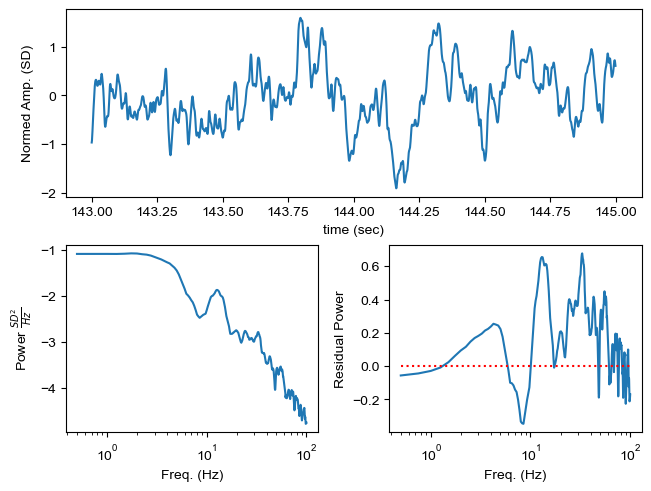

In [47]:
randix = rng.integers(0, high=resid_spects.shape[0])
randt = sts[randix]
plot_ixs = (ts>=randt-(t_win/2))&(ts<=randt+(t_win/2))

fig = plt.figure(layout="constrained")

gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(ts[plot_ixs],reref1[plot_ixs])
ax1.set_xlabel("time (sec)")
ax1.set_ylabel("Normed Amp. (SD)")

ax2.plot(f,np.log10(spectra[randix,:]))
ax2.set_xscale("log")
ax2.set_xlabel("Freq. (Hz)")
ax2.set_ylabel("Power "+ r'$\frac{SD^2}{Hz}$')

ax3.plot(f,resid_spects[randix,:])
ax3.plot([f[0],f[-1]],[0,0],"r:")
ax3.set_xlabel("Freq. (Hz)")
ax3.set_ylabel("Residual Power")
ax3.set_xscale("log")

In [ ]:
t0 = 48 #0
t1 = 52 #max(ts)
tfilt = (ts>t0) & (ts<=t1)
stfilt = (sts>=t0) & (sts<=t1)


In [ ]:
from matplotlib.gridspec import GridSpec
fig = plt.figure()
grid = GridSpec(2,1 , height_ratios=[1,4])
ax1 = fig.add_subplot(grid[0])
ax2 = fig.add_subplot(grid[1],sharex=ax1)

ax1.plot(ts[tfilt],reref[tfilt])
ax1.set_xlim([t0,t1])     
Y,X=np.meshgrid(f, sts[stfilt])
ax2.pcolormesh(X,Y,resid_spects[stfilt,:],vmin=0, vmax=1,
              cmap="grey",shading="nearest")
ax2.set_ylim([fmin,fmax])
ax2.set_yscale("log")
plt.show()

In [16]:
win_samps.shape

(1076, 2048)